In [40]:
# ----------------- #
# Scarlet 1 testing #
# ----------------- #
# Import Packages and setup
import numpy as np
import pandas as pd
import cmasher as cmr
import scarlet # install not working

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# use a good colormap and don't interpolate the pixels
matplotlib.rc('image', cmap=cmr.fall, interpolation='none', origin='lower')

Matt's section

In [41]:
# Data check
data_name = 'data_HSC_' + str(9697) + '_patch_' + str(72) + '.pkl' # checking things are ok
df = pd.read_pickle(data_name)
data = df[df['parent_ID']==df['parent_ID'][14000]] # select one randome scene
print(data.info())

# make multi-band data
multi_images = np.array([np.array(data['scene_g'])[0] , np.array(data['scene_r'])[0]  , np.array(data['scene_i'])[0]  , 
                        np.array(data['scene_y'])[0]  , np.array(data['scene_z'])[0] ]) 
multi_filters = np.array([np.array(data['mask_g'])[0] , np.array(data['mask_r'])[0]  , np.array(data['mask_i'])[0]  , 
                        np.array(data['mask_y'])[0]  , np.array(data['mask_z'])[0] ]) 
multi_var = np.array([np.array(data['var_g'])[0] , np.array(data['var_r'])[0]  , np.array(data['var_i'])[0]  , 
                        np.array(data['var_y'])[0]  , np.array(data['var_z'])[0] ]) 
multi_psf = np.array([np.array(data['PSF_g'])[0] , np.array(data['PSF_r'])[0]  , np.array(data['PSF_i'])[0]  , 
                        np.array(data['PSF_y'])[0]  , np.array(data['PSF_z'])[0] ]) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 12999 to 13002
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   parent_ID   4 non-null      int64 
 1   object_num  4 non-null      int64 
 2   box_x       4 non-null      int64 
 3   box_y       4 non-null      int64 
 4   tract       4 non-null      int64 
 5   patch       4 non-null      int64 
 6   box_sz      4 non-null      int64 
 7   loc         4 non-null      object
 8   scar_g      4 non-null      object
 9   scar_i      4 non-null      object
 10  scar_r      4 non-null      object
 11  scar_y      4 non-null      object
 12  scar_z      4 non-null      object
 13  PSF_g       4 non-null      object
 14  PSF_i       4 non-null      object
 15  PSF_r       4 non-null      object
 16  PSF_y       4 non-null      object
 17  PSF_z       4 non-null      object
 18  var_g       4 non-null      object
 19  var_i       4 non-null      object
 20  var_r 

In [42]:
# Load the sample images
images = multi_images 
masks = multi_filters
filters = np.array(['g','i','r','y','z'],dtype='<U1') # explicitly make filter list
centers = np.array( data['loc'] )
weights = 1/multi_var 
psf = scarlet.ImagePSF( multi_psf )

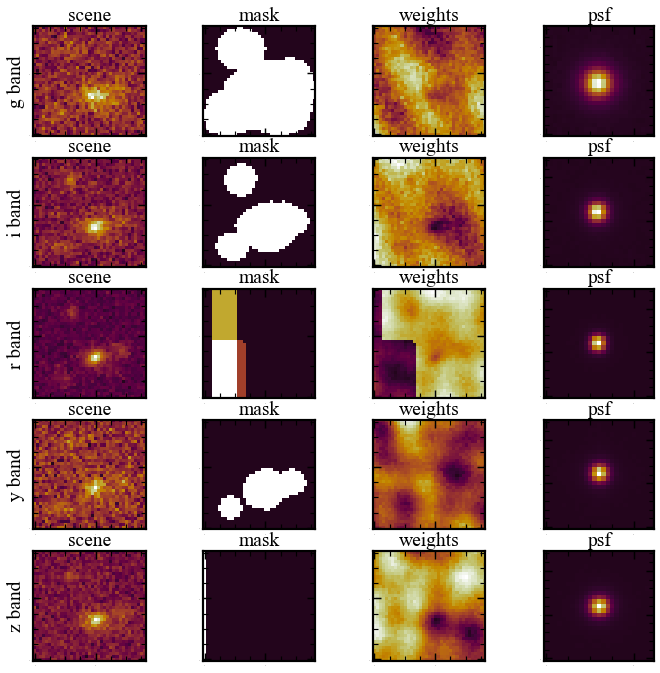

In [43]:
fig = plt.figure(figsize=(12, 12), dpi = 70)
num_bands = len(filters)
for i in range(num_bands):
    plt.subplot(num_bands,4,1+4*i)
    plt.title('scene', fontsize=20)
    plt.imshow( images[i] )
    name = filters[i] + ' band'
    plt.ylabel(name, fontsize=20)
    plt.xticks(fontsize=0)
    plt.yticks(fontsize=0)
    plt.subplot(num_bands,4,2+4*i)
    plt.title('mask', fontsize=20)
    plt.xticks(fontsize=0)
    plt.yticks(fontsize=0)
    plt.imshow( masks[i] )
    plt.subplot(num_bands,4,3+4*i)
    plt.title('weights', fontsize=20)
    plt.xticks(fontsize=0)
    plt.yticks(fontsize=0)
    plt.imshow( weights[i] )
    plt.subplot(num_bands,4,4+4*i)
    plt.title('psf', fontsize=20)
    plt.xticks(fontsize=0)
    plt.yticks(fontsize=0)
    plt.imshow( multi_psf[i] )

plt.show()

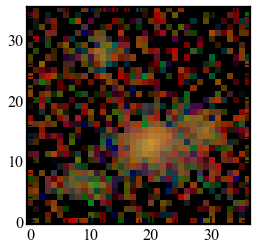

In [44]:
from scarlet.display import AsinhMapping

stretch = 0.2
Q = 10
norm = AsinhMapping(minimum=0, stretch=stretch, Q=Q)

img_rgb = scarlet.display.img_to_rgb(images, norm=norm)
plt.imshow(img_rgb)
plt.show()

In [45]:
model_psf = scarlet.GaussianPSF(sigma=(0.8,)*len(filters))

model_frame = scarlet.Frame(
    images.shape,
    psf=model_psf,
    channels=filters)

observation = scarlet.Observation(
    images,
    psf=psf,
    weights=weights,
    channels=filters).match(model_frame)

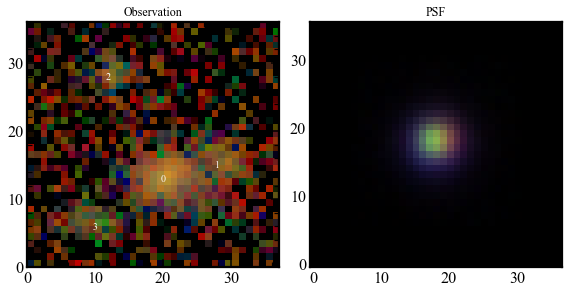

In [46]:
scarlet.display.show_observation(observation, norm=norm, sky_coords=centers, show_psf=True)
plt.show()

In [47]:
sources, skipped = scarlet.initialization.init_all_sources(model_frame,
                                                           centers,
                                                           observation,
                                                           max_components=2,
                                                           min_snr=50,
                                                           thresh=1,
                                                           fallback=True,
                                                           silent=True,
                                                           set_spectra=True
                                                          )

for k, src in enumerate(sources):
    print (f"{k}: {src.__class__.__name__}")

0: SingleExtendedSource
1: SingleExtendedSource
2: SingleExtendedSource
3: SingleExtendedSource


In [48]:
sources = []
for k,center in enumerate(centers):
    if k == 0:
        new_source = scarlet.PointSource(model_frame, center, observation)
    elif k in [1, 2]:
        new_source = scarlet.ExtendedSource(model_frame, center, observation, K=2)
    elif k in [3, 5]:
         new_source = scarlet.ExtendedSource(model_frame, center, observation, K=1)
    else:
         new_source = scarlet.ExtendedSource(model_frame, center, observation, compact=True)
    sources.append(new_source)

for k, src in enumerate(sources):
    print (f"{k}: {src.__class__.__name__}")



0: PointSource
1: MultiExtendedSource
2: MultiExtendedSource
3: SingleExtendedSource


CPU times: user 408 ms, sys: 3.9 ms, total: 411 ms
Wall time: 104 ms
scarlet ran for 18 iterations to logL = 7587.169341596064


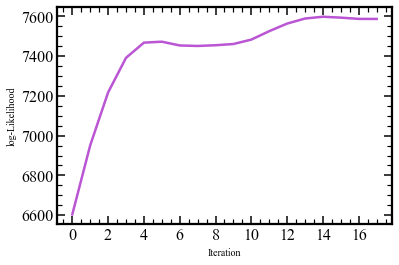

In [49]:
blend = scarlet.Blend(sources, observation)
%time it, logL = blend.fit(100, e_rel=1e-4)
print(f"scarlet ran for {it} iterations to logL = {logL}")
scarlet.display.show_likelihood(blend)
plt.show()

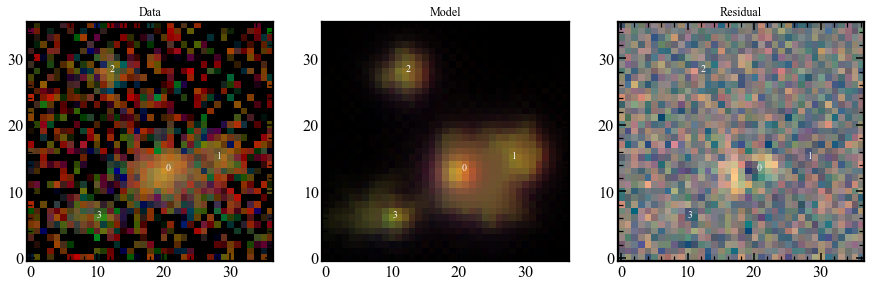

In [50]:
# Compute model
model = blend.get_model()
# Render it in the observed frame
model_ = observation.render(model)
# Compute residual
residual = images-model_

# Create RGB images
model_rgb = scarlet.display.img_to_rgb(model_, norm=norm)
residual_rgb = scarlet.display.img_to_rgb(residual)

# Show the data, model, and residual
fig = plt.figure(figsize=(15,5))
ax = [fig.add_subplot(1,3,n+1) for n in range(3)]
ax[0].imshow(img_rgb)
ax[0].set_title("Data")
ax[1].imshow(model_rgb)
ax[1].set_title("Model")
ax[2].imshow(residual_rgb)
ax[2].set_title("Residual")

for k,src in enumerate(blend):
    if hasattr(src, "center"):
        y,x = src.center
        ax[0].text(x, y, k, color="w")
        ax[1].text(x, y, k, color="w")
        ax[2].text(x, y, k, color="w")
plt.show()

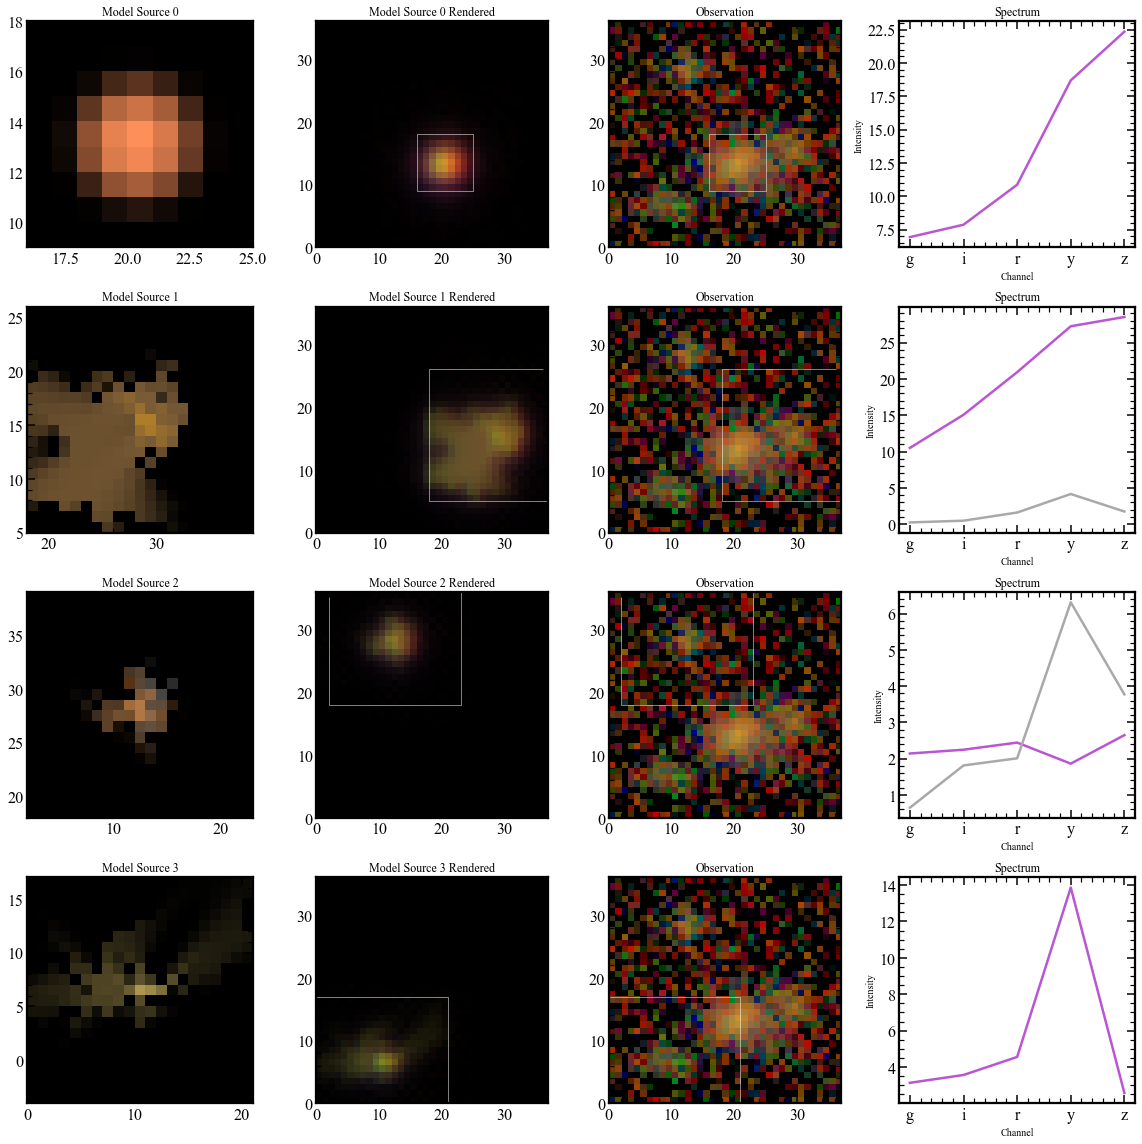

In [51]:
scarlet.display.show_sources(sources,
                             norm=norm,
                             observation=observation,
                             show_model=True,
                             show_rendered=True,
                             show_observed=True,
                             add_markers=False,
                             add_boxes=True
                            )
plt.show()

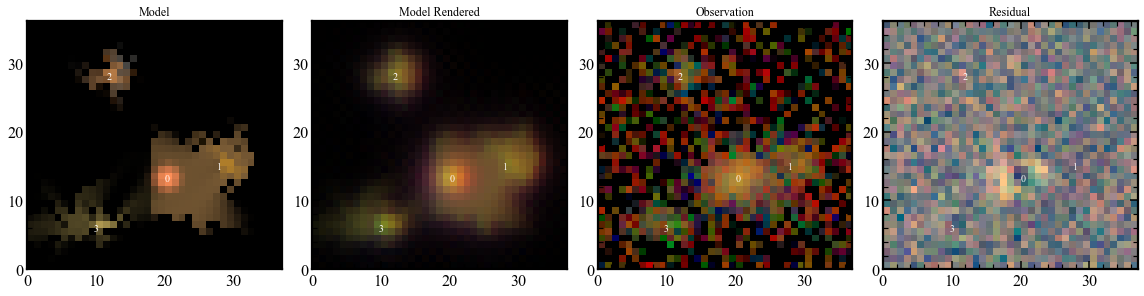

In [52]:
scarlet.display.show_scene(sources,
                           norm=norm,
                           observation=observation,
                           show_rendered=True,
                           show_observed=True,
                           show_residual=True)
plt.show()